## 1. 数据预处理

### 1.1 数据加载

In [44]:
import pandas as pd

# 选取 gene_expression, DNA methylation(450k), miRNA expression 数据
gene_expression_raw_data = pd.read_csv('data/gene_expression/batch_effects_normalized_mRNA_data', sep='\t', index_col=0)
dna_methylation_27k_raw_data = pd.read_csv('data/DNA_methylation/DNA_methylation_27k', sep='\t', index_col=0)
dna_methylation_450k_raw_data = pd.read_csv('data/DNA_methylation/DNA_methylation_450k', sep='\t', index_col=0)
miRNA_expression_raw_data = pd.read_csv('data/miRNA_expression/batch_effects_normalized_miRNA_data', sep='\t', index_col=0)

### 1.2 数据清洗

In [67]:
# 定义清理函数
def clean_data(data):
    data = data.dropna(axis=1, thresh=0.7*data.shape[0])
    data = data.apply(lambda row: row.fillna(row.mean()), axis=1)
    data = data.fillna(0)
    return data

# 清理每种数据
gene_expression_data = clean_data(gene_expression_raw_data)
dna_methylation_27k_data = clean_data(dna_methylation_27k_raw_data)
dna_methylation_450k_data = clean_data(dna_methylation_450k_raw_data)
miRNA_expression_data = clean_data(miRNA_expression_raw_data)

In [92]:
# 检查是否包含NaN值
print("Gene Expression Data contains NaN:", gene_expression_data.isnull().values.any())
print("DNA Methylation 27K Data contains NaN:", dna_methylation_27k_data.isnull().values.any())
print("DNA Methylation 450K Data contains NaN:", dna_methylation_450k_data.isnull().values.any())
print("miRNA Expression Data contains NaN:", miRNA_expression_data.isnull().values.any())

Gene Expression Data contains NaN: False
DNA Methylation 27K Data contains NaN: False
DNA Methylation 450K Data contains NaN: False
miRNA Expression Data contains NaN: False


### 1.3 数据标准化

### 2.2 数据整合

In [93]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

gene_expression_data_scaled = pd.DataFrame(scaler.fit_transform(gene_expression_data), 
                                           index=gene_expression_data.index, columns=gene_expression_data.columns)
dna_methylation_27k_data_scaled = pd.DataFrame(scaler.fit_transform(dna_methylation_27k_data), 
                                       index=dna_methylation_27k_data.index, columns=dna_methylation_27k_data.columns)
dna_methylation_450k_data_scaled = pd.DataFrame(scaler.fit_transform(dna_methylation_450k_data), 
                                       index=dna_methylation_450k_data.index, columns=dna_methylation_450k_data.columns)
miRNA_expression_data_scaled = pd.DataFrame(scaler.fit_transform(miRNA_expression_data), 
                                              index=miRNA_expression_data.index, columns=miRNA_expression_data.columns)


## 2. 数据整合

### 2.1 样本匹配

In [94]:
common_samples = set(gene_expression_data_scaled.columns) & \
                 set(dna_methylation_27k_data_scaled.columns) & \
                 set(dna_methylation_450k_data_scaled.columns) & \
                 set(miRNA_expression_data_scaled.columns)
                 
common_samples_list = list(common_samples)

gene_expression_data_scaled = gene_expression_data_scaled[common_samples_list]
dna_methylation_27k_data_scaled = dna_methylation_27k_data_scaled[common_samples_list]
dna_methylation_450k_data_scaled = dna_methylation_450k_data_scaled[common_samples_list]
miRNA_expression_data_scaled = miRNA_expression_data_scaled[common_samples_list]


### 2.2 数据整合

In [95]:
combined_data = pd.concat([gene_expression_data_scaled, 
                           dna_methylation_27k_data_scaled, 
                           dna_methylation_450k_data_scaled, 
                           miRNA_expression_data_scaled], axis=0)


## 3. 聚类分析


In [99]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(combined_data.T)

# 将聚类结果添加到数据集中
combined_data = combined_data.T
combined_data['Cluster'] = clusters
combined_data = combined_data.T


/home/ldz/Documents/anaconda3/envs/cluster/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## 4. 结果分析和可视化

### 4.1 聚类结果分析

In [100]:
cluster_summary = combined_data.T.groupby('Cluster').mean()
print(cluster_summary)


         100130426  100133144  100134869     10357     10431    136542  \
Cluster                                                                  
0.0      -1.451602  -0.885348  -0.988872  0.633974  0.947122 -1.458568   
1.0      -1.455277  -0.837203  -0.791055  0.692828  0.852618 -1.462259   
2.0      -1.458408  -0.886612  -0.893663  0.631062  0.882157 -1.465399   
3.0      -1.506316  -0.819925  -0.890271  0.635490  0.819681 -1.513384   
4.0      -1.564835  -0.946843  -0.839149  0.190235  0.851951 -1.573466   

           155060     26823    280660    317712  ...  hsa-miR-527  \
Cluster                                          ...                
0.0      0.759424 -1.007028 -1.432896 -1.458353  ...    -0.836931   
1.0      0.910705 -0.947766 -1.436528 -1.462043  ...    -0.875948   
2.0      0.899615 -1.010817 -1.439635 -1.465183  ...    -0.849308   
3.0      0.761235 -1.039294 -1.487337 -1.513166  ...    -0.896469   
4.0      0.149932 -1.422451 -1.564259 -1.573389  ...    -0.814857  

### 4.2 聚类结果可视化

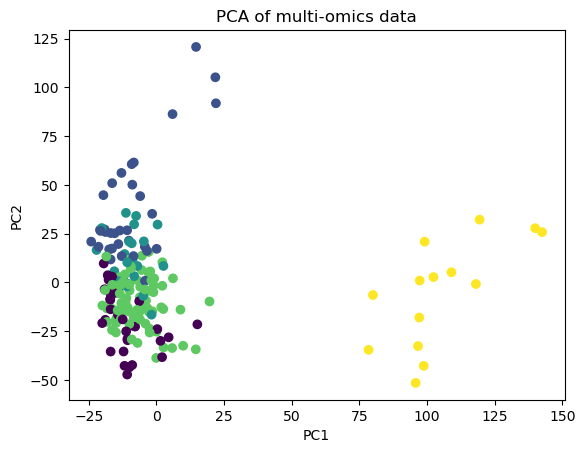

In [101]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data.T.drop('Cluster', axis=1))

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=combined_data.T['Cluster'], cmap='viridis')
plt.title('PCA of multi-omics data') 
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
